<a href="https://colab.research.google.com/github/Lucas-C-Vargas/Image-Transmission-via-Audio-File/blob/main/Audio_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final - Transmissão de Imagens via Arquivos de Áudio
---

*ÁUDIO → IMAGEM*

**Alunos:**
- Lucas de Carvalho Vargas (0039109)
- Pedro Henrique Lopes Matias (0039112)

### Bibliotecas

In [ ]:
# Bibliotecas utilizadas no projeto
import numpy as np # Numpy para produção de matrizes
import matplotlib.pyplot as plt # Matplotlib para plotar imagens
from scipy import signal
from scipy.io import wavfile # Usado para processar arquivos .WAV
from scipy.fft import fft
from PIL import Image # Usado para processar imagens
from IPython.display import Audio # Usado para processar arquivos de audio
from os import path # Navega nos diretórios
from google.colab import files

### Conexões e Vínculos

In [ ]:
# Clona o repositório Git do projeto
if path.exists('Git') == False:
    !git clone https://github.com/Lucas-C-Vargas/Image-Transmission-via-Audio-File.git Git
else:
    !rm -rf 'Git'
    !git clone https://github.com/Lucas-C-Vargas/Image-Transmission-via-Audio-File.git Git

Cloning into 'Git'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 42 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (42/42), 1.23 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (8/8), done.


### Funções

In [ ]:
def fourier(x, t, Hz=True, dB=False, deg=False, Nfft=None):
    '''
    Calculates the Magnitude, Phase e Frequencies of a signal x(t).
    ```

    # PARAMETERS:
    - x: array_like with amplitudes (time domain)
    - t: array_like with time stamps (time domain)
    - Hz: boolean, optional
       >>> False → rad/s
       >>> True → Hz
    - dB: boolean, optional
       >>> False → no units
       >>> True → dB
    - deg: boolean, optional
       >>> False → rad
       >>> True → degrees
    - Nfft: int, optional

    # RETURNS:
    - mag: array_like
    - phase: array_like
    - freq: array_like
    ```
    '''

    N = len(x) # Quantidade de amostras do vetor x

    # Se Nfft não for declarado, utiliza os N pontos do sinal
    if Nfft==None: Nfft=N

    T = np.mean(t[1:] - t[:-1]) # Período de amostragem

    # Calcula FFT
    Xf = fft(x, n=Nfft)/N # Corrige a amplitude na frequencia
    Xf[1:] = 2*Xf[1:] # Dobra amplitudes
    Xf = Xf[:Nfft//2] # Descarta simetria na frequencia

    # Obtém módulo e fase da FFT
    mag = np.abs(Xf)
    phase = np.angle(Xf, deg)

    # Verifica cálculo da amplitude em dB
    if dB:
        mag = 20*np.log10(mag) # Converte amplitude em dB

    # Calcula o vetor de frequências
    if Hz:
        # Vetor de frequências [Hz]
        freq0 = 1/(T*Nfft)
        freq = np.arange(0, Nfft*freq0, freq0)
    else:
        # Vetor de frequências [rad/s]
        w0 = 2*np.pi/(T*Nfft)
        freq = np.arange(0, Nfft*w0, w0)
    freq = freq[:Nfft//2] # Descarta simetria na frequencia

    return mag, phase, freq

In [ ]:
def grayscale(rgb=[0, 0, 0]):
    '''
    Calculates and returns the Grayscale component for a RGB color.
    '''

    color = int(0.30*rgb[0] + 0.59*rgb[1] + 0.11*rgb[2]) # Escala de cinza ponderada
    return color

In [ ]:
def extract_pixels(image, RGB=False):
    '''
    Returns an array with the color components for every pixel, added by 1.
    Starts on the upper left pixel, moving horizontally, on a zigzag patern.
    The signal is inverted on every "line" break.
    ```

    # PARAMETERS:
    - image: PIL.Image.Image
    - RGB: boolean, optional
    >>> False → Grayscale (1 value per pixel)
    >>> True → RGB (3 values per pixel)

    # RETURNS:
    - signal: array_like
    ```
    '''

    width, height = image.size # Dimensões da imagem
    signal = [] # Inicia um vetor vazio

    if RGB: # Sinal com 3 componentes por pixel (RGB)
        for y in range(height):
            if y%2 == 0: # Insere as informações das componentes RGB no vetor, com sinal positivo
                for x in range(width):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    signal.append(rgb[0]+1) # Red
                    signal.append(rgb[1]+1) # Green
                    signal.append(rgb[2]+1) # Blue
            else: # Insere as informações das componentes RGB no vetor, com sinal negativo
                for x in range(width-1, -1, -1):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    signal.append(-rgb[0]-1) # Red
                    signal.append(-rgb[1]-1) # Green
                    signal.append(-rgb[2]-1) # Blue
    else: # Sinal com 1 componente por pixel (Grayscale)
        for y in range(height):
            if y%2 == 0: # Insere a informação da componente Grayscale no vetor, com sinal positivo
                for x in range(width):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    color = grayscale(rgb) # Converte para escala de cinza (ponderada)
                    signal.append(color+1)
            else: # Insere a informação da componente Grayscale no vetor, com sinal negativo
                for x in range(width-1, -1, -1):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    color = grayscale(rgb) # Converte para escala de cinza (ponderada)
                    signal.append(-color-1)

    return signal

In [ ]:
def extract_pixels_linear(image, RGB=False):
    '''
    Returns an array with the color components for every pixel, added by 1.
    Starts on the upper left pixel, moving horizontally, on a liner patern.
    The signal is inverted on every "line" break.
    ```

    # PARAMETERS:
    - image: PIL.Image.Image
    - RGB: boolean, optional
       >>> False → Grayscale (1 value per pixel)
       >>> True → RGB (3 values per pixel)

    # RETURNS:
    - signal: array_like
    ```
    '''

    width, height = image.size # Dimensões da imagem
    signal = [] # Inicia um vetor vazio

    if RGB: # Sinal com 3 componentes por pixel (RGB)
        for y in range(height):
            if y%2 == 0: # Insere as informações das componentes RGB no vetor, com sinal positivo
                for x in range(width):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    signal.append(rgb[0]+1) # Red
                    signal.append(rgb[1]+1) # Green
                    signal.append(rgb[2]+1) # Blue
            else: # Insere as informações das componentes RGB no vetor, com sinal negativo
                for x in range(width):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    signal.append(-rgb[0]-1) # Red
                    signal.append(-rgb[1]-1) # Green
                    signal.append(-rgb[2]-1) # Blue
    else: # Sinal com 1 componente por pixel (Grayscale)
        for y in range(height):
            if y%2 == 0: # Insere a informação da componente Grayscale no vetor, com sinal positivo
                for x in range(width):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    color = grayscale(rgb) # Converte para escala de cinza (ponderada)
                    signal.append(color+1)
            else: # Insere a informação da componente Grayscale no vetor, com sinal negativo
                for x in range(width):
                    rgb = image.getpixel((x, y)) # Componentes RGB do pixel
                    color = grayscale(rgb) # Converte para escala de cinza (ponderada)
                    signal.append(-color-1)

    return signal

In [ ]:
def calc_dimensions(signal, RGB=False):
    '''
    Calculates and returns the dimensions from the original image.
    ```

    # PARAMETERS:
    - signal: array_like
    - RGB: boolean, optional
    >>> False → Grayscale (1 value per pixel)
    >>> True → RGB (3 values per pixel)

    # RETURNS:
    - width: int (pixels)
    - heigth: int (pixels)
    ```
    '''

    height = 1; # Inicia o contador de linhas

    # Detecta estado inicial de sinal das componentes
    if signal[0] >= 0:
        positive = True
    else:
        positive = False

    # Detecta mudança de sinal das componentes (quebra de linha)
    for x in range(len(signal)):
        if positive and (signal[x] < 0): # Borda de descida
            positive = False
            height = height + 1
        if not(positive) and (signal[x] > 0): # Borda de subida
            positive = True
            height = height + 1

    # Calcula largura da imagem de acordo com o sistema de cores utilizado
    width = len(signal)/height
    if RGB:
        width = width/3

    return int(width), int(height)

In [ ]:
def image_build(signal, RGB = False):
    '''
    Rebuilds an Image from the signal obtained using "extract_pixels" function.
    Starts on the upper left pixel, moving horizontally, on a zigzag patern.

    ```

    # PARAMETERS:
    - signal: content from .wav file
    - RGB: boolean, optional
       >>> False → Grayscale (1 value per pixel)
       >>> True → RGB (3 values per pixel)

    # RETURNS:
    - image: PIL.Image.Image
    ```
    '''

    # Calcula as dimensões da imagem
    width, height = calc_dimensions(signal, RGB)

    # Define a escala de cor da imagem
    if RGB:
        image = Image.new('RGB', (width, height), color=(0,0,0))
        for y in range(height):
            if y%2 == 0:
                for x in range(width):
                    image.putpixel((x, y), (abs(signal[(3*x + 0 + y*3*width)])-1,
                                            abs(signal[(3*x + 1 + y*3*width)])-1,
                                            abs(signal[(3*x + 2 + y*3*width)])-1))
            else:
                for x in range(width-1, -1, -1):
                    image.putpixel((x, y), (abs(signal[(3*(width-1-x) + 0 + y*3*width)])-1,
                                            abs(signal[(3*(width-1-x) + 1 + y*3*width)])-1,
                                            abs(signal[(3*(width-1-x) + 2 + y*3*width)])-1))
    else:
        image = Image.new('L', (width, height), color=(0))
        for y in range(height):
            if y%2 == 0: # Insere a informação da componente Grayscale no vetor, com sinal positivo
                for x in range(width):
                    image.putpixel((x, y), abs(signal[(x + y*width)])-1)
            else: # Insere a informação da componente Grayscale no vetor, com sinal negativo
                for x in range(width-1, -1, -1):
                    image.putpixel((x, y), abs(signal[(width-1-x + y*width)])-1)

    return image

In [ ]:
def image_build_linear(signal, RGB = False):
    '''
    Rebuilds an Image from the signal obtained using "extract_pixels_linear" function.
    Starts on the upper left pixel, moving horizontally, on a linear patern.

    ```

    # PARAMETERS:
    - signal: content from .wav file
    - RGB: boolean, optional
       >>> False → Grayscale (1 value per pixel)
       >>> True → RGB (3 values per pixel)

    # RETURNS:
    - image: PIL.Image.Image
    ```
    '''

    # Calcula as dimensões da imagem
    width, height = calc_dimensions(signal, RGB)

    # Define a escala de cor da imagem
    if RGB:
        image = Image.new('RGB', (width, height), color=(0,0,0))
        for y in range(height):
            for x in range(width):
                image.putpixel((x, y), (abs(signal[(3*x + 0 + y*3*width)])-1,
                                        abs(signal[(3*x + 1 + y*3*width)])-1,
                                        abs(signal[(3*x + 2 + y*3*width)])-1))
    else:
        image = Image.new('L', (width, height), color=(0))
        for y in range(height):
            for x in range(width):
                image.putpixel((x, y), abs(signal[(x + y*width)])-1)

    return image

### Entrada (Imagem)

Saving GitHub_Logo.png to GitHub_Logo.png


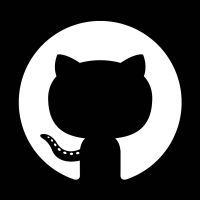

In [ ]:
RGB = True

# Imagem de exemplo (Logo do IFMG)
# image = Image.open('Git/Images/IFMG_Logo.jpeg')

uploaded = files.upload()

for fn in uploaded.keys():
    if (len(uploaded)) == 1:
        image = Image.open(fn)
    !rm "{fn}"

image

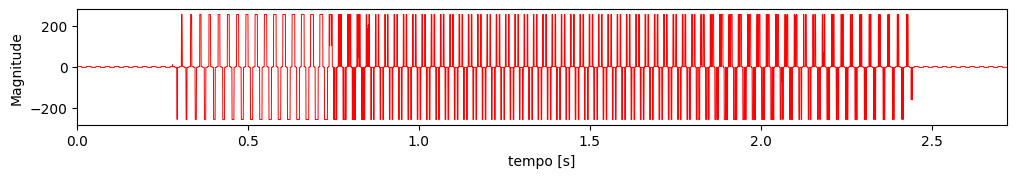

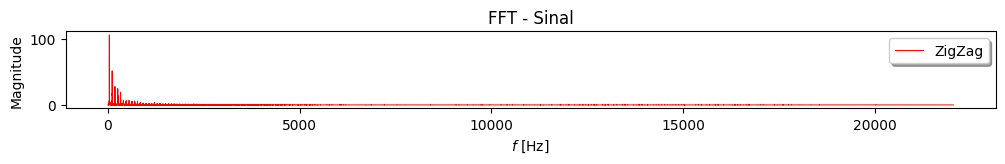

In [ ]:
signal = extract_pixels(image, RGB)

fs = 44100 # Frequência de amostragem
tempo = np.arange(len(signal))/fs

plt.figure(figsize=(12, 1.5))
plt.plot(tempo, signal, lw=.7, c='r', label="ZigZag")
plt.xlabel("tempo [s]")
plt.ylabel("Magnitude")
plt.xlim((0, max(tempo)))

mag, phase, freq = fourier(signal, tempo, Hz=True, dB=False, deg=True, Nfft=None)

plt.figure(figsize=(12, 1))
plt.title("FFT - Sinal")
plt.plot(freq, mag, lw=.7, c='r', label="ZigZag")
plt.xlabel("$f$ [Hz]")
plt.ylabel("Magnitude")
plt.legend(loc=1, shadow=True, bbox_to_anchor=(1, 1))

Audio(signal, rate=fs, normalize=True)

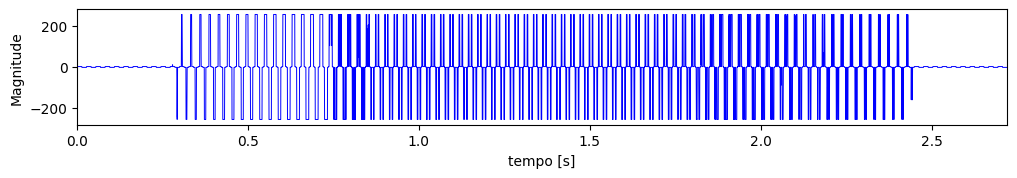

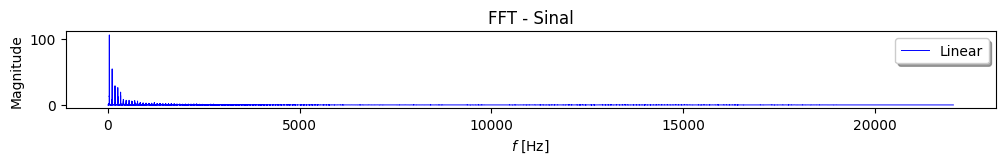

In [ ]:
signal_lin = extract_pixels_linear(image, RGB)

plt.figure(figsize=(12, 1.5))
plt.plot(tempo, signal_lin, lw=.7, c='b', label="Linear")
plt.xlabel("tempo [s]")
plt.ylabel("Magnitude")
plt.xlim((0, max(tempo)))

mag_lin, phase_lin, freq_lin = fourier(signal_lin, tempo, Hz=True, dB=False, deg=True, Nfft=None)

plt.figure(figsize=(12, 1))
plt.title("FFT - Sinal")
plt.plot(freq_lin, mag_lin, lw=.7, c='b', label="Linear")
plt.xlabel("$f$ [Hz]")
plt.ylabel("Magnitude")
plt.legend(loc=1, shadow=True, bbox_to_anchor=(1, 1))

Audio(signal_lin, rate=fs, normalize=True)

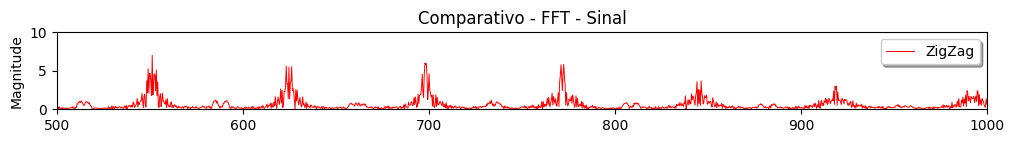

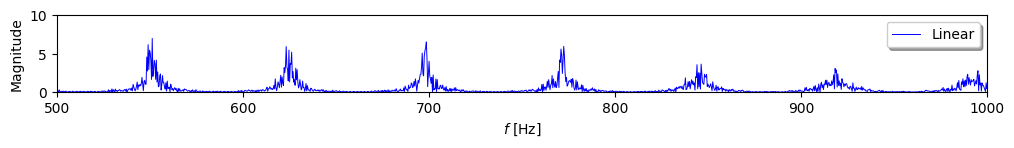

In [ ]:
x_min = 500
x_max = 1000

plt.figure(figsize=(12, 1))
plt.title("Comparativo - FFT - Sinal")
plt.plot(freq, mag, lw=.7, c='r', label="ZigZag")
plt.xlim(x_min, x_max)
plt.ylim(0, 10)
plt.ylabel("Magnitude")
plt.legend(loc=1, shadow=True, bbox_to_anchor=(1, 1))

plt.figure(figsize=(12, 1))
plt.plot(freq_lin, mag_lin, lw=.7, c='b', label="Linear")
plt.xlim(x_min, x_max)
plt.ylim(0, 10)
plt.xlabel("$f$ [Hz]")
plt.ylabel("Magnitude")
plt.legend(loc=1, shadow=True, bbox_to_anchor=(1, 1))

### Entrada (Áudio) - WIP

In [ ]:
w1, h1 = calc_dimensions(signal, RGB)
w1, h1

(171, 192)

(0.0, 0.5)

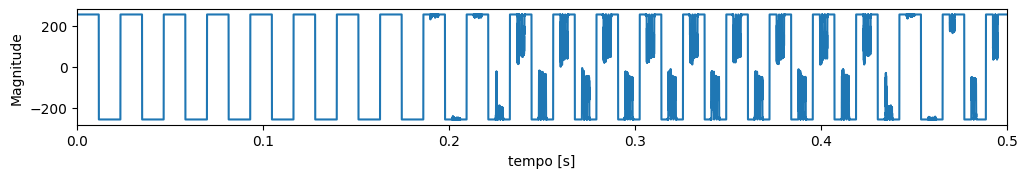

In [ ]:
plt.figure(figsize=(12, 1.5))
plt.plot(tempo, signal_lin)
plt.xlabel("tempo [s]")
plt.ylabel("Magnitude")
plt.xlim((0, 0.5))

### Reconstrução da Imagem

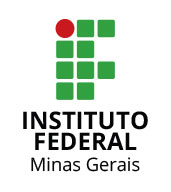

In [ ]:
image2 = image_build(signal, RGB)
image2

Text(0, 0.5, 'Magnitude')

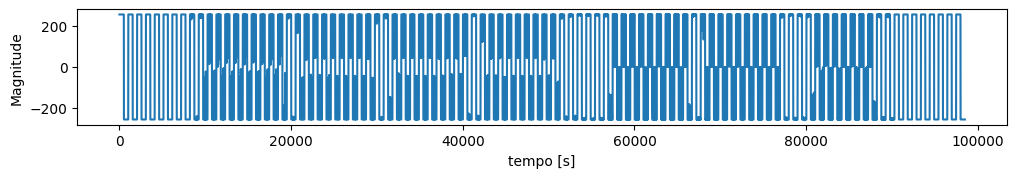

In [ ]:
plt.figure(figsize=(12, 1.5))
plt.plot(np.arange(len(signal)), signal)
plt.xlabel("tempo [s]")
plt.ylabel("Magnitude")


In [ ]:
# Image Transmission via Audio File

# Image to Audio
'''

'''

# Audio to Image
'''
1 - Inserir arquivo de audio
2 - Obter sinal "criptografado" (demodulação e/ou demultiplexação)
3 - Reconstruir imagem
'''

'\n1 - Inserir arquivo de audio\n2 - Obter sinal "criptografado" (demodulação e/ou demultiplexação)\n3 - Reconstruir imagem\n'

### Entrada (Audio)

In [ ]:
# Arquivo de Audio (.wav)
arq = requests.get(file_url)
open("input.wav", "wb").write(arq.content)
fs, audio = wavfile.read('input.wav')
audio = audio[10000:100000, 0] # sinal do diapasão

Audio(audio, rate=fs, normalize=True)

NameError: ignored

[//]: Rodapé
# <center> --- </center>

---

<center>
  <img
    src="https://drive.google.com/uc?export=view&id=1nHTWpJNRG-PMsewxoHzlCYARkTwPQIrw"
    alt="Empty_PNG"
    align="left"
    height="50"
    width="50"
  />
  <img
    src="https://drive.google.com/uc?export=view&id=1m_rzpQJQOZ1Kd3RBA5KkY0dm-_Swlg4_"
    alt="Logo IFMG"
    align="left"
    height="50"
  />
  <img
    src="https://drive.google.com/uc?export=view&id=1nHTWpJNRG-PMsewxoHzlCYARkTwPQIrw"
    alt="Empty_PNG"
    align="right"
    height="50"
    width="50"
  />
  <img
    src="https://drive.google.com/uc?export=view&id=1m_rzpQJQOZ1Kd3RBA5KkY0dm-_Swlg4_"
    alt="Empty_PNG"
    align="right"
    height="50"
    width="50"
  />
  <figcaption>Instituto Federal de Educação, Ciência e tecnologia de Minas Gerais - Campus Betim</figcaption>
  <figcaption>Processamento de Sinais - 2023.2</figcaption>
</center>

---